# 코드살펴보기

## 라이브러리 불러오기

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

### 불러온 데이터는 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미합니다.

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68616192/68606236 [==============================] - 0s 0us/step


### train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.



In [8]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [9]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


### train 데이터와 validation 데이터의 개수 확인

In [10]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### 파라미터 설정 조절 - 성능 상향

In [38]:
batch_size = 16
epochs = 77
IMG_HEIGHT = 256
IMG_WIDTH = 256

### 데이터 시각화

In [31]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다. Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [32]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다. Classification task에 따라 class_mode를 변경하시면 됩니다.

In [33]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


### Data Augmentation이 제대로 되었는지 확인

In [15]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

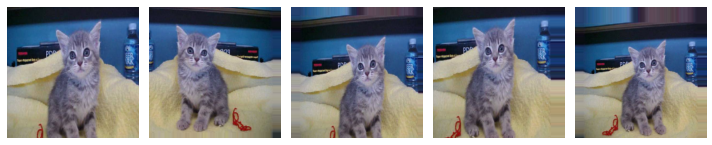

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.



In [17]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [18]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성이 되어 있습니다.



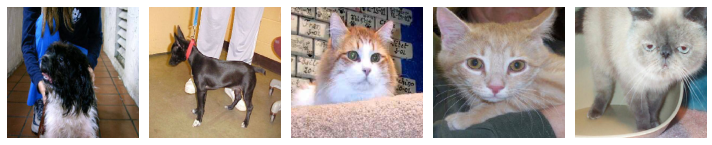

In [19]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

### 정답 데이터 확인

In [20]:
_[:5]

array([1., 1., 0., 0., 0.], dtype=float32)

### 모델 구현

In [34]:
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 128)     1475

In [35]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

### 모델학습

In [39]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/77
125/125 [==============================] - 41s 330ms/step - loss: 0.6899 - binary_accuracy: 0.5585 - val_loss: 0.6860 - val_binary_accuracy: 0.5460
Epoch 2/77
125/125 [==============================] - 41s 326ms/step - loss: 0.6955 - binary_accuracy: 0.5520 - val_loss: 0.6996 - val_binary_accuracy: 0.5530
Epoch 3/77
125/125 [==============================] - 41s 328ms/step - loss: 0.6817 - binary_accuracy: 0.5510 - val_loss: 0.7051 - val_binary_accuracy: 0.5550
Epoch 4/77
125/125 [==============================] - 41s 327ms/step - loss: 0.6790 - binary_accuracy: 0.5645 - val_loss: 0.6889 - val_binary_accuracy: 0.5310
Epoch 5/77
125/125 [==============================] - 41s 327ms/step - loss: 0.6808 - binary_accuracy: 0.5610 - val_loss: 0.6818 - val_binary_accuracy: 0.5550
Epoch 6/77
125/125 [==============================] - 41s 327ms/step - loss: 0.6713 - binary_accuracy: 0.5805 - val_loss: 0.6904 - val_binary_accuracy: 0.5390
Epoch 7/77
125/125 [==========================

### 데이터 시각화

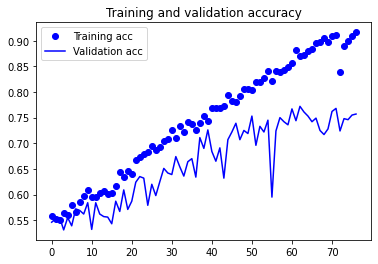

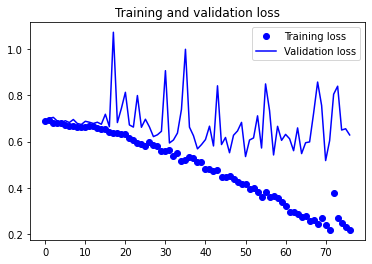

In [40]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 이후 파라미터 설정/제너레이터 생성/모델구현과 같은 작업으로 정확도를 올릴 수 있다.